In [1]:
import os
import numpy as np
import keras
import tensorflow as tf
from keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import sigmoid

In [2]:
!git clone https://github.com/Leoehz/Auto-Alimentador-de-Mascotas.git

Cloning into 'Auto-Alimentador-de-Mascotas'...
remote: Enumerating objects: 461, done.
remote: Counting objects: 100% (254/254), done.
remote: Compressing objects: 100% (253/253), done.
remote: Total 461 (delta 1), reused 252 (delta 0), pack-reused 207
Receiving objects: 100% (461/461), 165.30 MiB | 35.15 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
!ls Auto-Alimentador-de-Mascotas/Dataset

lleno  vacio


In [4]:
# Descartar imagenes corruptas
num_skipped = 0
for folder_name in ("lleno", "vacio"):
    folder_path = os.path.join("Auto-Alimentador-de-Mascotas/Dataset", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = b"JFIF" in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print(f"Deleted {num_skipped} images.")

Deleted 0 images.


In [5]:
# Cargar set de datos
image_size = (224, 224)
batch_size = 10

train_ds, val_ds = keras.utils.image_dataset_from_directory(
    "Auto-Alimentador-de-Mascotas/Dataset",
    validation_split=0.2,
    subset="both",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 240 files belonging to 2 classes.
Using 192 files for training.
Using 48 files for validation.


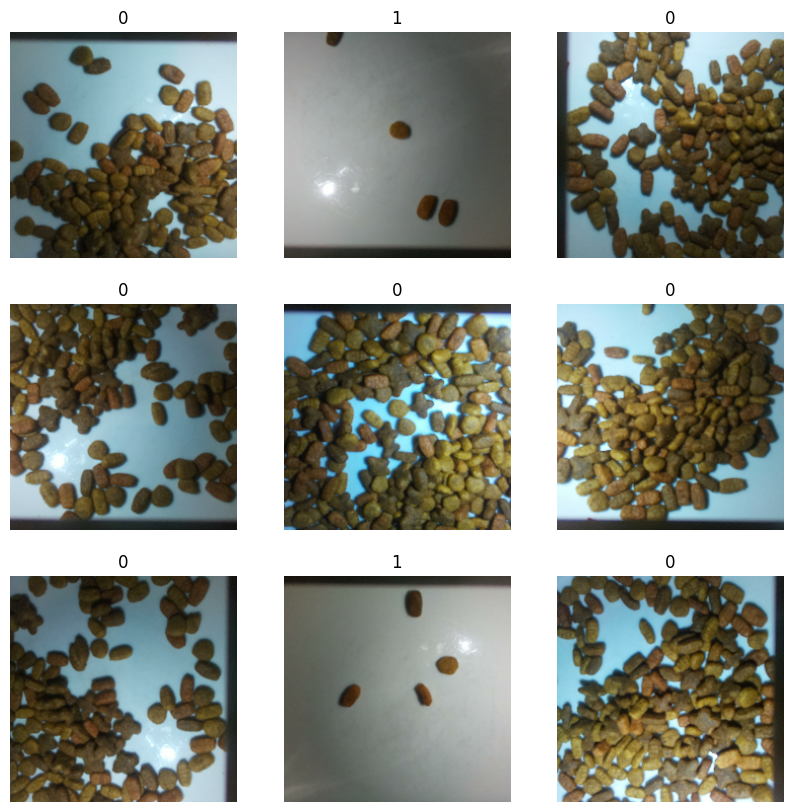

In [6]:
# Ver Imagenes cargadas

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
# Etapa de data augmentation
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

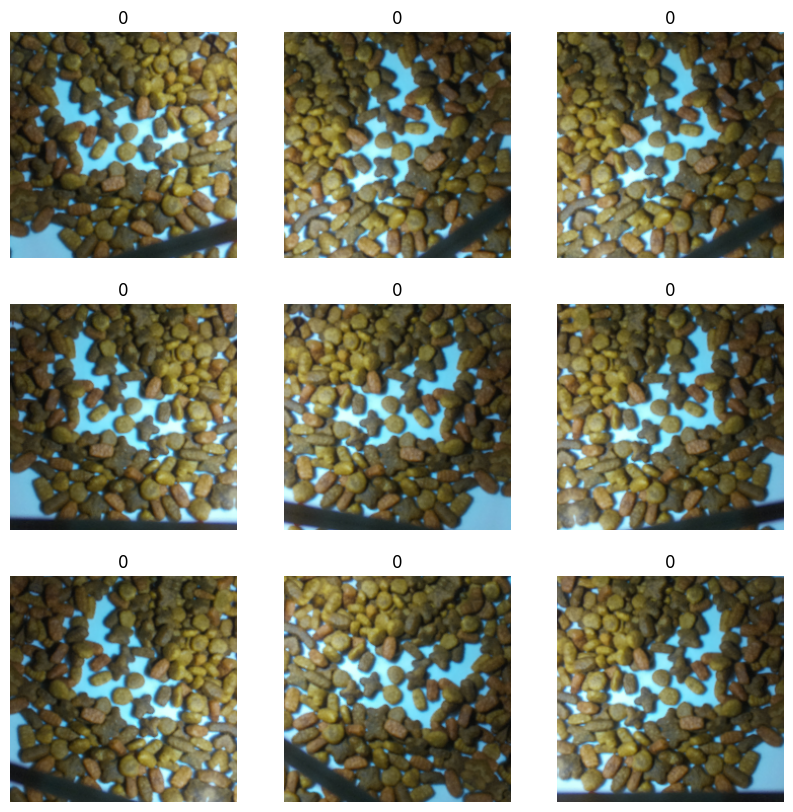

In [8]:
# Ver resultado de aplicar data augmentation
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.title(int(labels[0]))
        plt.axis("off")

In [9]:
# Aplicamos `data_augmentation` al set de imagenes de entrenamiento.
da_train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf_data.AUTOTUNE,
)

In [10]:
# Aplicando funcion de Pre-Procesamiento del modelo

pp_train_ds = da_train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)
pp_val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE)

# Precargando los recursos en la memoria de la GPU para maximizar su utilizacion.
pp_train_ds = pp_train_ds.prefetch(tf_data.AUTOTUNE)
pp_val_ds = pp_val_ds.prefetch(tf_data.AUTOTUNE)

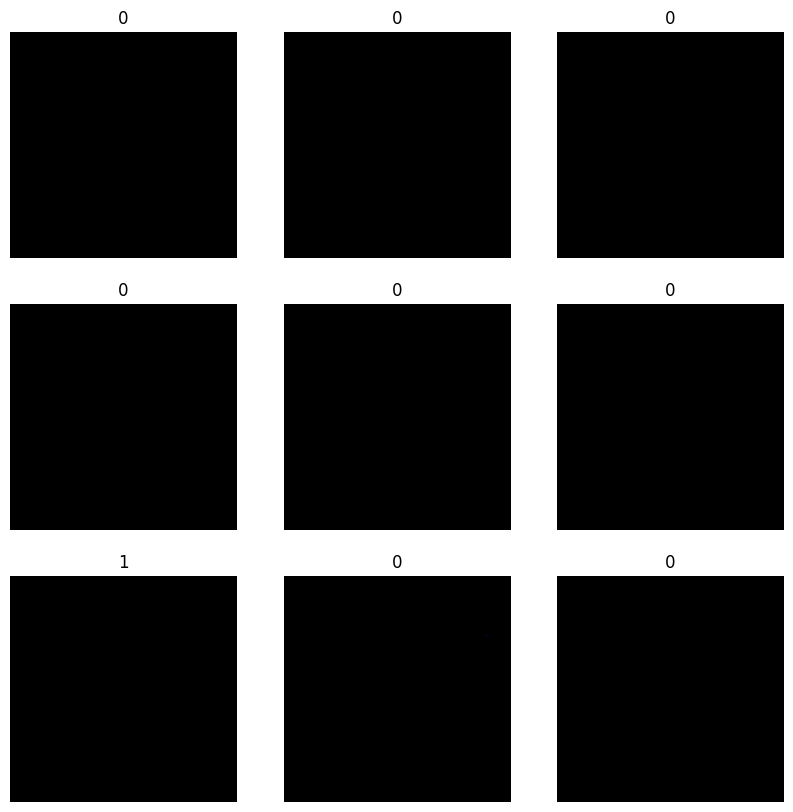

In [11]:
# Ver imagenes Pre-Procesadas
plt.figure(figsize=(10, 10))
for images, labels in pp_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(images[i]).astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

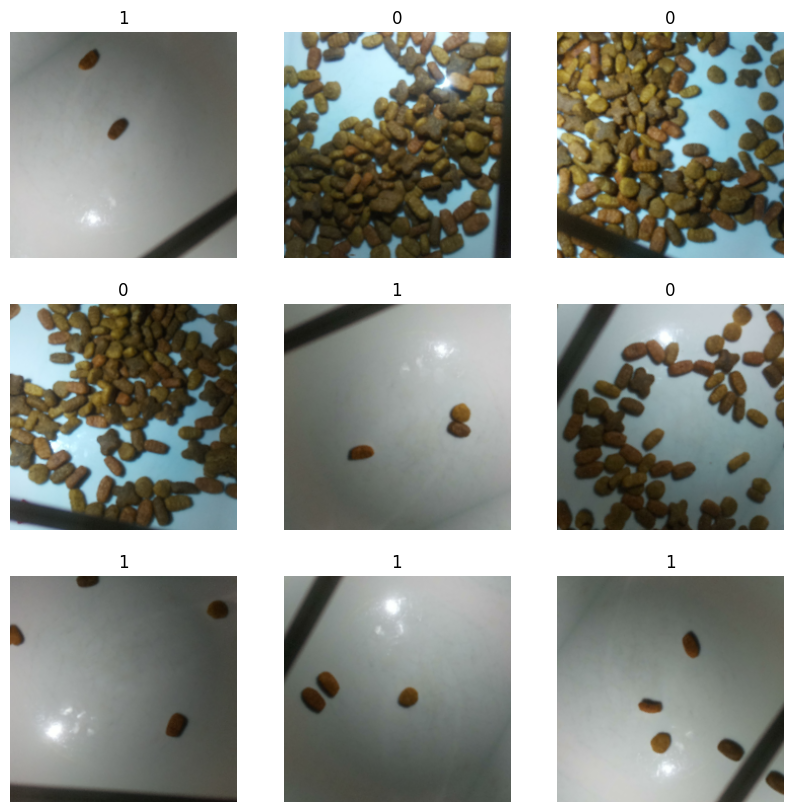

In [12]:
# Imagenes Pre-Procesadas desprocesadas
plt.figure(figsize=(10, 10))

def deprocess_image(image):
    image = (image + 1.0) / 2.0  # Cambiar de [-1, 1] a [0, 1]
    return tf.clip_by_value(image, 0.0, 1.0)

for images, labels in pp_train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        image = deprocess_image(images[i])
        plt.imshow(image)
        plt.title(int(labels[i]))
        plt.axis("off")

In [15]:
# Creacion del Modelo
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

# Añadir nuestras propias capas superiores
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
  # La activacion sigmoid es buena para clasificacion de 2 clases.
predictions = Dense(1, activation='sigmoid')(x)

# Crear el modelo completo
model = Model(inputs=base_model.input, outputs=predictions)

# Compilar el modelo
model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])


In [16]:
# Cargamos el modelos
epochs = 10

history = model.fit(
    pp_train_ds,
    epochs=epochs,
    validation_data=pp_val_ds
)

Epoch 1/10
20/20 [==============================] - 7s 100ms/step - loss: 0.0315 - accuracy: 0.9792 - val_loss: 2.9740e-07 - val_accuracy: 1.0000
Epoch 2/10
20/20 [==============================] - 2s 79ms/step - loss: 1.2320e-06 - accuracy: 1.0000 - val_loss: 1.5998e-07 - val_accuracy: 1.0000
Epoch 3/10
20/20 [==============================] - 2s 79ms/step - loss: 1.7921e-07 - accuracy: 1.0000 - val_loss: 1.1879e-07 - val_accuracy: 1.0000
Epoch 4/10
20/20 [==============================] - 2s 74ms/step - loss: 2.3342e-07 - accuracy: 1.0000 - val_loss: 1.0013e-07 - val_accuracy: 1.0000
Epoch 5/10
20/20 [==============================] - 3s 117ms/step - loss: 9.1782e-09 - accuracy: 1.0000 - val_loss: 9.5482e-08 - val_accuracy: 1.0000
Epoch 6/10
20/20 [==============================] - 2s 80ms/step - loss: 1.4754e-07 - accuracy: 1.0000 - val_loss: 8.6257e-08 - val_accuracy: 1.0000
Epoch 7/10
20/20 [==============================] - 2s 78ms/step - loss: 2.5361e-08 - accuracy: 1.0000 - val

In [17]:
!ls Auto-Alimentador-de-Mascotas/Dataset/lleno/muestra16_0.jpg

Auto-Alimentador-de-Mascotas/Dataset/lleno/muestra16_0.jpg


1/1 [==============================] - 0s 52ms/step
This image is 26.89% full and 73.11% empty.


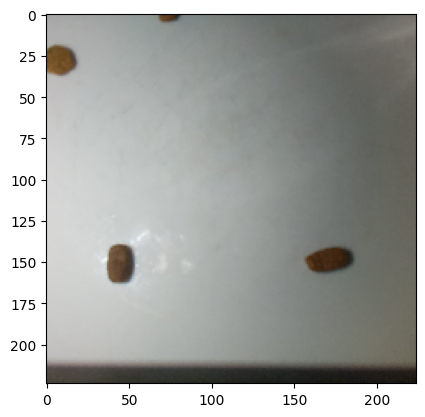

In [30]:
img = keras.utils.load_img("Auto-Alimentador-de-Mascotas/Dataset/vacio/muestra20_0.jpg", target_size=image_size)
plt.imshow(img)

img_array = keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
#img_array = keras.ops.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
score = float(sigmoid(predictions[0][0]))
print(f"This image is {100 * (1 - score):.2f}% full and {100 * score:.2f}% empty.")
